# Business Problem

Francois is a young artist from Toronto looking to open a contemporary art gallery in a modern, 
stylish city to display some of his eccentric pieces. He knows that Montreal, a city about 6-hour drive 
from Toronto, is often referred to as the creative hub of Canada. He has packed his bags and moved 
to Montreal in hope to open start his dream of bringing conceptual art to an exciting city. Despite his 
eagerness and energy, he has little knowledge of Montreal and needs to figure out the perfect 
location to open his gallery. Francois has described his art to be bold, inspiring, and thought-provoking. He thinks the gallery will attract the following people:
1.	Young professionals
2.	People comfortable with liberal ideology (his art expresses major social issues)  
3.	Artistic minds

He has also commented that he wants his gallery to have an exclusive presence, and not just some 
gallery on the intersection of a busy, high-traffic area. 

His business goals are to:
1. Sell his work
2. Foster a community of art lovers
3. Gain as much exposure in the art community

Where in Montreal should Francois open his gallery?


# Analysis

In [108]:
import urllib.request
import pandas as pd
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from bs4 import BeautifulSoup
import bs4
import geocoder
import folium 
import requests
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
import re
import xml.etree.ElementTree as ET
import lxml


#### Scrape Neighborhood Data

In [109]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_H'
page = urllib.request.urlopen(url)

In [110]:
soup = BeautifulSoup(page,'html.parser')

In [111]:
my_table=soup.find('table')

In [112]:
pc=[]

for row in my_table.findAll('b'):
    cell=row.text
    if cell == "Reserved":
        pass 
    else:
        pc.append(cell)

In [113]:
nbh=[]

for row in my_table.findAll('p'):
    lst2= []
    for i in row.findAll('span'):
        if isinstance(i, bs4.Tag):
            i=i.text
            i=re.sub(r"\B([A-Z])", r" \1", i)
            lst2.append(i)
    nbh.append(lst2)

In [114]:
# create dataframe out of two columns
df= pd.DataFrame(pc, columns=['Postcode'])
df['Neighbourhood'] = nbh
df['Neighbourhood'] = df['Neighbourhood'].str[0]

In [115]:
# drop unassigned neighbourhoods
clean = df[~df.Neighbourhood.isin(['Not assigned', '\nNot assigned\n'])].reset_index(drop=True)

# clean up some records
clean.Neighbourhood[clean.Neighbourhood == 'Reserved0 H0: Santa Claus'] = 'Santa Claus'

# final scraped df
clean

,Postcode,Neighbourhood
0,H1A,Pointe-aux-Trembles
1,H2A,Saint-Michel East
2,H3A,Downtown Montreal North(Mc Gill University)
3,H4A,Notre-Dame-de-Grâce Northeast
4,H5A,Place Bonaventure
...,...,...
118,H1Z,Saint-Michel West
119,H2Z,Downtown Montreal Northeast
120,H3Z,Westmount South
121,H4Z,Tour de la Bourse


#### Geocode neighbourhoods

In [116]:
## adding the column for latitude
clean['Latitude'] = ' '

## adding the column for longitude
clean['Longitude'] = ' '

clean['City'] = ''

In [117]:
# Function that generates the url for the Bing Maps (Microsoft) API

def getUrl(x):

    ## concatenating the coordinates to generate the url
    url = 'http://dev.virtualearth.net/REST/v1/Locations/' + str(x)+', QC, Canada' + '?o=xml&key=Zll6jqYBc6SzPIY7Ndfa~J6EC-Danv8Uz7sL5hwQECg~AmvX1nTWjQkqEBK2iffRcGCf81qlHPZP_I4ACLKSt71I5X7ISKxPuNoSBhg_Keke'

    ## returning the url
    return url


# Function that pulls longitude and latitude using API

def getGeo(url):

    ## getting the data from api
    r = requests.get(url)
    root = ET.fromstring(r.content)

    ## getting the latitude

    for child in root.iter('{http://schemas.microsoft.com/search/local/ws/rest/v1}Latitude'):
        latitude=child.text
        break
    

    ## getting the longitude
    for child in root.iter('{http://schemas.microsoft.com/search/local/ws/rest/v1}Longitude'):
        longitude= child.text
        break
        
    ## return coordinates
    return(latitude,longitude)



def getCity(url):
    r = requests.get(url)
    root = ET.fromstring(r.content)
    
    for child in root.iter('{http://schemas.microsoft.com/search/local/ws/rest/v1}Locality'):
        city= child.text
        break
        
    ## return coordinates
    return(city)

In [118]:
# For loop that gets the latitude and longitude for each address and adds to dataset
# columns 'latitude' and 'longitude'.
# If address is broken, skip.

for i in clean.index:

    ## read address from dataset
    x = clean.loc[i, 'Postcode']

    ## get the corresponding url using Location information
    url = getUrl(x)

    ## get the latitude and longitude from the url
    lat,long = getGeo(url)

    ## add latitude to the dataset
    clean.loc[i, 'Latitude'] = float(lat)

    ## add longitude to the dataset
    clean.loc[i, 'Longitude'] = float(long)
    
    ###
    try:
        city = getCity(url)
        clean.loc[i, 'City'] = city
    except:
        clean.loc[i, 'City'] = clean.loc[i,'Neighbourhood']
    
    
        


In [119]:
clean

,Postcode,Neighbourhood,Latitude,Longitude,City
0,H1A,Pointe-aux-Trembles,45.6741,-73.5004,Montreal
1,H2A,Saint-Michel East,45.5615,-73.6001,Montreal
2,H3A,Downtown Montreal North(Mc Gill University),45.504,-73.5758,Montreal
3,H4A,Notre-Dame-de-Grâce Northeast,45.474,-73.6159,Montreal
4,H5A,Place Bonaventure,45.4993,-73.5652,Montreal
...,...,...,...,...,...
118,H1Z,Saint-Michel West,45.5728,-73.6203,Montreal
119,H2Z,Downtown Montreal Northeast,45.5054,-73.5615,Montreal
120,H3Z,Westmount South,45.4828,-73.5919,Montreal
121,H4Z,Tour de la Bourse,45.5009,-73.5607,Montreal


In [120]:
# Exclude cities 'Laval' and 'Dundee' since we are only looking at Montreal
# The rest we can keep because they are still neighbourhoods in Montreal

filters= (clean.City != "Laval") & (clean.City != "Dundee")
clean = clean.loc[filters]


In [121]:
# look to see if each location in dataset is unique
test= clean.Latitude.astype(str) +', '+ clean.Longitude.astype(str)
test.value_counts()



53.00788879394531, -70.9957275390625      2
45.633201599121094, -73.52835845947266    1
45.503990173339844, -73.57577514648438    1
45.47921371459961, -73.78091430664062     1
45.455299377441406, -73.87885284423828    1
                                         ..
45.443599700927734, -73.5836181640625     1
45.4780387878418, -73.69522857666016      1
45.49017333984375, -73.63104248046875     1
45.512550354003906, -73.56758880615234    1
45.4857292175293, -73.57325744628906      1
Length: 103, dtype: int64

In [122]:
# it seems we have one duplicate. 
# Drop Santa Claus since it apears to be in 'Quebec City'
clean= clean[clean.Postcode!='H0H']

In [123]:
# final dataset
clean.shape

(103, 5)

#### Start mapping neighbourhoods

In [124]:
mtl_lat = 45.499974
mtl_long =  -73.566916

# create map of Montreal using latitude and longitude values
map_mtl = folium.Map(location=[mtl_lat, mtl_long], zoom_start=12)

In [125]:
# add markers to map
for lat, lng, neighbourhood in zip(clean['Latitude'], clean['Longitude'], clean['Neighbourhood']):
    label = folium.Popup(neighbourhood, max_width=300,min_width=100, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_mtl)  
    
map_mtl

### Extract Venue Data

In [126]:
CLIENT_ID = 'D1D3SAPTCL4HIOAPSCO00Q5H5NSBDKHCV2CARVUDIETSL1CX' # Foursquare ID
CLIENT_SECRET = 'W0A5KO41JBLHXMVJGAIDCJWJ5DBJIE5D1BKFXGREN2LHZXNM' # Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [127]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [128]:
mtl_venues = getNearbyVenues(names=clean['Neighbourhood'],
                                   latitudes=clean['Latitude'],
                                   longitudes=clean['Longitude'])

Pointe-aux-Trembles
Saint-Michel East
Downtown Montreal North(Mc Gill University)
Notre-Dame-de-Grâce Northeast
Place Bonaventure
Dollard-des-Ormeaux Northwest
Montreal East
Ahuntsic North
Downtown Montreal East
Notre-Dame-de-Grâce Southwest
Place Desjardins
Dollard-des-Ormeaux East
Rivière-des-Prairies Northeast
Ahuntsic Central
Griffintown(Includes Île Notre-Dame & Île Sainte-Hélène)(Université de Montréal)
Saint-Henri
L'Île-Bizard Northeast
Rivière-des-Prairies Southwest
Villeray Northeast
L'Île-Des-Soeurs
Ville Émard
L'Île-Bizard Southwest
Montréal-Nord North
Petite-Patrie Northeast
Downtown Montreal Southeast (Concordia University)
Verdun North
Dollard-des-Ormeaux Southwest
Montréal-Nord South
Plateau Mont-Royal North
Downtown Montreal Southwest
Verdun South
Sainte-Geneviève / Pierrefonds
Anjou West
Plateau Mont-Royal North Central
Petite-Bourgogne
Cartierville Central
Kirkland
Anjou East
Centre-Sud North
Pointe-Saint-Charles
Cartierville Southwest
Senneville
Mercier North
Centre-

In [129]:
#See how many venues per neighbourhood
# Seems like foursquare doesn't retrieve all venues for each neighbourhood
mtl_venues.groupby('Neighbourhood').Venue.count().sort_values().head(20)

Neighbourhood
Mercier Southeast                 1
Hampstead / Côte Saint-Luc        1
Anjou West                        1
Beaconsfield                      1
Senneville                        1
Ville Saint-Pierre                1
Lachine East                      2
Kirkland                          2
Saint-Laurent Southeast           2
Saint-Laurent Southwest           2
Mount Royal North                 2
Verdun South                      2
Sainte-Anne-De-Bellevue           2
Pointe-aux-Trembles               2
Saint-Laurent Central             2
Saint-Laurent Outer Northeast     3
Cartierville Central              3
Sainte-Geneviève / Pierrefonds    3
Dollard-des-Ormeaux Northwest     3
Saint-Michel West                 3
Name: Venue, dtype: int64

### Analyze Each Neighborhood

In [130]:
print('There are {} uniques categories.'.format(len(mtl_venues['Venue Category'].unique())))

There are 261 uniques categories.


In [131]:
# one hot encoding
mtl_onehot = pd.get_dummies(mtl_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighbourhood column back to dataframe
mtl_onehot['Neighbourhood'] = mtl_venues['Neighbourhood'] 

# move neighbourhood column to the first column
fixed_columns = [mtl_onehot.columns[-1]] + list(mtl_onehot.columns[:-1])
mtl_onehot = mtl_onehot[fixed_columns]

mtl_onehot.head()

,Neighbourhood,ATM,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Tunnel,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Women's Store,Yoga Studio,Zoo
0,Pointe-aux-Trembles,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Pointe-aux-Trembles,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Saint-Michel East,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Saint-Michel East,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Saint-Michel East,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [132]:
mtl_grouped = mtl_onehot.groupby('Neighbourhood').mean().reset_index()
mtl_grouped.head()

,Neighbourhood,ATM,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Tunnel,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Women's Store,Yoga Studio,Zoo
0,Ahuntsic Central,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.055556,0.0,0.0,0.0,0.0,0.0,0.0
1,Ahuntsic East,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,Ahuntsic North,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0
3,Ahuntsic Southeast,0.0,0.0,0.0,0.0,0.0625,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,Ahuntsic Southwest,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [133]:
# These Neighbourhoods did not return Venues

for i in np.array(clean.Neighbourhood):
    if i in np.array(mtl_grouped.Neighbourhood):
        continue
    else:
            print(i)

Montreal East
L'Île-Bizard Southwest
Vimont
Lachine West
Montreal West
Dorval Central (Y U L)


In [134]:
num_top_venues = 5

for hood in mtl_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = mtl_grouped[mtl_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['VENUE','FREQ']
    temp = temp.iloc[1:]
    temp['FREQ'] = temp['FREQ'].astype(float)
    temp = temp.round({'FREQ': 2})
    print(temp.sort_values('FREQ', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Ahuntsic Central----
             VENUE  FREQ
0             Café  0.11
1              Bar  0.06
2  Organic Grocery  0.06
3      Coffee Shop  0.06
4    Grocery Store  0.06


----Ahuntsic East----
                    VENUE  FREQ
0                    Park  0.29
1  Furniture / Home Store  0.14
2                     Spa  0.14
3        Football Stadium  0.14
4                  Office  0.14


----Ahuntsic North----
                   VENUE  FREQ
0            Dry Cleaner  0.17
1          Grocery Store  0.17
2              Pet Store  0.17
3  Vietnamese Restaurant  0.17
4     Italian Restaurant  0.17


----Ahuntsic Southeast----
                 VENUE  FREQ
0       Clothing Store  0.19
1   Italian Restaurant  0.12
2    Electronics Store  0.06
3                 Park  0.06
4  American Restaurant  0.06


----Ahuntsic Southwest----
            VENUE  FREQ
0  Breakfast Spot   0.2
1  Ice Cream Shop   0.2
2         Dog Run   0.2
3      Restaurant   0.2
4    Liquor Store   0.2


----Anjou East----
 

In [135]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = mtl_grouped['Neighbourhood']

for ind in np.arange(mtl_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(mtl_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ahuntsic Central,Café,Coffee Shop,Ice Cream Shop,Organic Grocery,Bar,Cheese Shop,Bakery,Restaurant,Italian Restaurant,Sushi Restaurant
1,Ahuntsic East,Park,Athletics & Sports,Furniture / Home Store,Office,Football Stadium,Spa,Falafel Restaurant,Factory,Event Space,Event Service
2,Ahuntsic North,Dry Cleaner,Pharmacy,Vietnamese Restaurant,Pet Store,Italian Restaurant,Grocery Store,Dumpling Restaurant,Electronics Store,Empada House,Empanada Restaurant
3,Ahuntsic Southeast,Clothing Store,Italian Restaurant,Bank,Café,Electronics Store,Bakery,Park,Furniture / Home Store,Sandwich Place,Pharmacy
4,Ahuntsic Southwest,Breakfast Spot,Restaurant,Dog Run,Liquor Store,Ice Cream Shop,Empada House,Empanada Restaurant,English Restaurant,Event Service,Event Space
...,...,...,...,...,...,...,...,...,...,...,...
92,Villeray Northeast,Bakery,Cheese Shop,Gas Station,Vietnamese Restaurant,Pharmacy,Thai Restaurant,Theater,Deli / Bodega,Sandwich Place,Sushi Restaurant
93,Villeray Southeast,Café,Breakfast Spot,Bakery,Peruvian Restaurant,Ice Cream Shop,Martial Arts Dojo,Spanish Restaurant,Boutique,French Restaurant,Sushi Restaurant
94,Villeray West,Café,Pharmacy,Liquor Store,Sushi Restaurant,Breakfast Spot,Discount Store,Butcher,Brewery,Sporting Goods Shop,Lounge
95,Westmount North,Park,Athletics & Sports,Dog Run,Tennis Court,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Factory,Event Space,Dry Cleaner


### Cluster Neighbourhoods

In [137]:
# set number of clusters
kclusters = 5

mtl_grouped_clustering = mtl_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(mtl_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:] 

array([1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 4, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 4, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 3, 1, 1, 1, 1, 1, 0, 1, 0, 3, 1,
       1, 1, 4, 1, 1, 1, 1, 0, 1], dtype=int32)

In [138]:
# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [139]:
neighbourhoods_venues_sorted

,Cluster Labels,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Ahuntsic Central,Café,Coffee Shop,Ice Cream Shop,Organic Grocery,Bar,Cheese Shop,Bakery,Restaurant,Italian Restaurant,Sushi Restaurant
1,0,Ahuntsic East,Park,Athletics & Sports,Furniture / Home Store,Office,Football Stadium,Spa,Falafel Restaurant,Factory,Event Space,Event Service
2,1,Ahuntsic North,Dry Cleaner,Pharmacy,Vietnamese Restaurant,Pet Store,Italian Restaurant,Grocery Store,Dumpling Restaurant,Electronics Store,Empada House,Empanada Restaurant
3,1,Ahuntsic Southeast,Clothing Store,Italian Restaurant,Bank,Café,Electronics Store,Bakery,Park,Furniture / Home Store,Sandwich Place,Pharmacy
4,1,Ahuntsic Southwest,Breakfast Spot,Restaurant,Dog Run,Liquor Store,Ice Cream Shop,Empada House,Empanada Restaurant,English Restaurant,Event Service,Event Space
...,...,...,...,...,...,...,...,...,...,...,...,...
92,1,Villeray Northeast,Bakery,Cheese Shop,Gas Station,Vietnamese Restaurant,Pharmacy,Thai Restaurant,Theater,Deli / Bodega,Sandwich Place,Sushi Restaurant
93,1,Villeray Southeast,Café,Breakfast Spot,Bakery,Peruvian Restaurant,Ice Cream Shop,Martial Arts Dojo,Spanish Restaurant,Boutique,French Restaurant,Sushi Restaurant
94,1,Villeray West,Café,Pharmacy,Liquor Store,Sushi Restaurant,Breakfast Spot,Discount Store,Butcher,Brewery,Sporting Goods Shop,Lounge
95,0,Westmount North,Park,Athletics & Sports,Dog Run,Tennis Court,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Factory,Event Space,Dry Cleaner


In [140]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighbourhood
mtl_merged = clean.merge(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood', how="inner")

In [141]:
mtl_merged.shape

(97, 16)

#### NOTE THAT THIS PART WILL CHANGE AFTER RERUNNING API
- this is because API finds venues 
- this notebook might be inconsistent with analysis

### Visualize the resulting clusters

In [144]:
# create map
map_clusters = folium.Map(location=[mtl_lat, mtl_long], zoom_start=11,tiles='Stamen Toner')


# # set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(mtl_merged['Latitude'], mtl_merged['Longitude'], mtl_merged['Neighbourhood'], mtl_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Examine Clusters

In [61]:
# c0 = mtl_merged.loc[mtl_merged['Cluster Labels'] == 0, mtl_merged.columns[list(range(6, mtl_merged.shape[1]))]]
# clust0 = mtl_merged.loc[mtl_merged['Cluster Labels'] == 0]

# insert= []
# for num in range(len(c0)):
#     for i in c0.values[num]:
#         insert.append(i)

# # Visualize
# import collections
# counter=collections.Counter(insert)
# counter_df = pd.Series(counter)
# plt.figure(figsize=(20,10))
# plt.bar(height=counter_df.values/len(c0),x=counter_df.index)
# plt.xticks(rotation=90)
# plt.ylabel('Occurrences')
# plt.title('Cluster {} Top Venues'.format(clust0['Cluster Labels'].iloc[2]))
# plt.show()

In [153]:
len(clust0xx.columns)

263

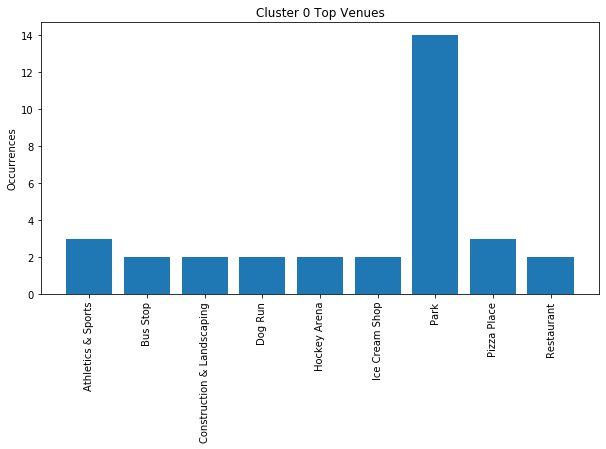

In [159]:
import matplotlib.pyplot as plt

lala = mtl_onehot.merge(mtl_merged[['Cluster Labels','Neighbourhood']],on='Neighbourhood', how='left')
clust0xx = lala.loc[lala['Cluster Labels'] == 0]

insert = []
for i in range(1,clust0xx.shape[1]-1):
    summit = clust0xx.iloc[:,i].sum()
    insert.append(summit)
    
xxx = pd.Series(data=insert, index=list(clust0xx.columns[1:262]))
xxx = xxx[xxx >1]

# Visualize
plt.figure(figsize=(10,5))
plt.bar(height=xxx.values, x=xxx.index)
plt.xticks(rotation=90)
plt.ylabel('Occurrences')
plt.title('Cluster {} Top Venues'.format(clust0xx['Cluster Labels'].iloc[2]))
plt.show()


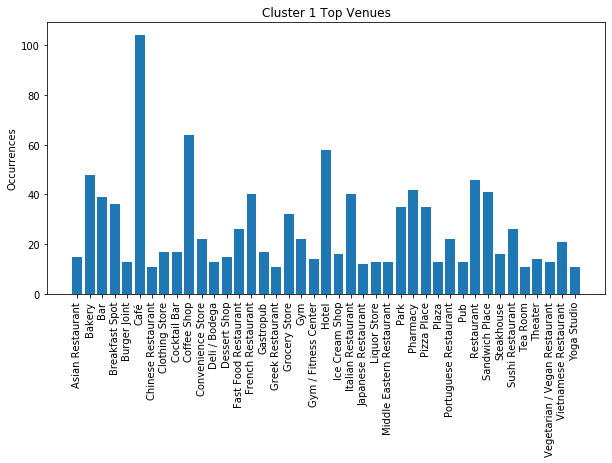

In [167]:
# mtl_merged.loc[mtl_merged['Cluster Labels'] == 1, mtl_merged.columns[[1] + list(range(5, mtl_merged.shape[1]))]].head(20)

lala = mtl_onehot.merge(mtl_merged[['Cluster Labels','Neighbourhood']],on='Neighbourhood', how='left')
clust0xx = lala.loc[lala['Cluster Labels'] == 1]

insert = []
for i in range(1,clust0xx.shape[1]-1):
    summit = clust0xx.iloc[:,i].sum()
    insert.append(summit)
    
xxx = pd.Series(data=insert, index=list(clust0xx.columns[1:262]))
xxx = xxx[xxx >10]

# Visualize
plt.figure(figsize=(10,5))
plt.bar(height=xxx.values, x=xxx.index)
plt.xticks(rotation=90)
plt.ylabel('Occurrences')
plt.title('Cluster {} Top Venues'.format(clust0xx['Cluster Labels'].iloc[2]))
plt.show()

In [168]:
lala = mtl_onehot.merge(mtl_merged[['Cluster Labels','Neighbourhood']],on='Neighbourhood', how='left')
clust3xx = lala.loc[lala['Cluster Labels'] == 2]

insert = []
for i in range(1,clust3xx.shape[1]-1):
    summit = clust3xx.iloc[:,i].sum()
    insert.append(summit)
    
xxx = pd.Series(data=insert, index=list(clust3xx.columns[1:262]))
xxx = xxx[xxx>0]
xxx

Event Service    1
dtype: int64

In [148]:
# c2 = mtl_merged.loc[mtl_merged['Cluster Labels'] == 2, mtl_merged.columns[list(range(6, mtl_merged.shape[1]))]]
# clust2 = mtl_merged.loc[mtl_merged['Cluster Labels'] == 2]

# insert= []
# for num in range(len(c2)):
#     for i in c2.values[num]:
#         insert.append(i)

# # # Visualize
# counter=collections.Counter(insert)
# counter_df = pd.Series(counter)
# counter_df = counter_df[counter_df>5]

# plt.figure(figsize=(20,10))
# plt.bar(height=counter_df.values/len(c2),x=counter_df.index)
# plt.xticks(rotation=90)
# plt.ylabel('Occurrences')
# plt.title('Cluster {} Top Venues'.format(clust2['Cluster Labels'].iloc[2]))
# plt.show()

In [169]:
# mtl_merged.loc[mtl_merged['Cluster Labels'] == 3, mtl_merged.columns[[1] + list(range(5, mtl_merged.shape[1]))]].head(20)


lala = mtl_onehot.merge(mtl_merged[['Cluster Labels','Neighbourhood']],on='Neighbourhood', how='left')
clust3xx = lala.loc[lala['Cluster Labels'] == 3]

insert = []
for i in range(1,clust3xx.shape[1]-1):
    summit = clust3xx.iloc[:,i].sum()
    insert.append(summit)
    
xxx = pd.Series(data=insert, index=list(clust3xx.columns[1:262]))
xxx = xxx[xxx ==1]
xxx

Sandwich Place    1
dtype: int64

In [170]:
# mtl_merged.loc[mtl_merged['Cluster Labels'] == 4, mtl_merged.columns[[1] + list(range(5, mtl_merged.shape[1]))]].head(20)


lala = mtl_onehot.merge(mtl_merged[['Cluster Labels','Neighbourhood']],on='Neighbourhood', how='left')
clust3xx = lala.loc[lala['Cluster Labels'] == 4]

insert = []
for i in range(1,clust3xx.shape[1]-1):
    summit = clust3xx.iloc[:,i].sum()
    insert.append(summit)
    
xxx = pd.Series(data=insert, index=list(clust3xx.columns[1:262]))
xxx = xxx[xxx >0]
xxx

Furniture / Home Store    2
Gym                       2
Hockey Arena              1
Theme Park                1
dtype: int64

#### Chosen Cluster:
It seems like cluster 1 is the best choice for what Francois is looking for.

Note that this will change after running the FourSquare API 

In [172]:
clust1=mtl_merged.loc[mtl_merged['Cluster Labels'] == 1]


## Search for Nearby Art Venues using Foursquare API

### Search for Nearby Art Venues
using: <https://developer.foursquare.com/docs/resources/categories>

In [ ]:
# root_art_category = '4d4b7104d754a06370d81259' # 'Root' category for all Arts & Entertainment venues

# art_gallery_category = ['4bf58dd8d48988d1e2931735']

# examples are ampitheaters, outdoor art installations, art galleries, concert hall, indie movie theatre, Museums


In [174]:
def getVenue_Number(category, latitudes, longitudes, radius=500):
    
    venues_number=[]
    for lat, lng in zip(latitudes, longitudes):
        try:
        # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}'.format(
                CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, category, radius)
            
        # make the GET request
            result = requests.get(url).json()['response']['totalResults']
        
        # return only relevant information for each nearby venue
            venues_number.append(result)
        except:
            pass
    
    return(venues_number)



In [175]:
RootArt2= getVenue_Number(category='4d4b7104d754a06370d81259', latitudes = clust1['Latitude'], longitudes=clust1['Longitude'])
ArtGal2=getVenue_Number(category='4bf58dd8d48988d1e2931735', latitudes = clust1['Latitude'], longitudes=clust1['Longitude'])

In [177]:
clust1['Art & Entertainment'] = RootArt2
clust1['Art Galleries'] = ArtGal2


/Users/margaritarojkova/venv/py3_venv1/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/margaritarojkova/venv/py3_venv1/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [178]:
venues=mtl_venues.groupby('Neighbourhood').Venue.count()
clust1=pd.merge(clust1, venues, on='Neighbourhood')
clust1['Art & Entertainment'] = clust1['Art & Entertainment']/clust1['Venue']
clust1['Art Galleries'] = clust1['Art Galleries']/clust1['Venue']

In [182]:
final_df=clust1.sort_values(by=['Art Galleries'],ascending=False).head(5)
final_df
final_df.drop(final_df.columns[2:16], axis=1)

,Postcode,Neighbourhood,Art & Entertainment,Art Galleries,Venue
76,H3Z,Westmount South,0.857143,0.285714,7
31,H2K,Centre-Sud North,0.653846,0.269231,26
53,H1S,Saint-Léonard Southeast,0.250000,0.250000,4
40,H2N,Ahuntsic Southeast,0.250000,0.187500,16
60,H3T,Côte-des-Neiges Northeast,0.666667,0.166667,6


It is noted that the "venue" numbers don't always include art galleries.
That number is only for most popular Venues only

Also note that for most common venue columns you only look at the number of total venues there are.

In [184]:
# create map
map_clusters = folium.Map(location=[mtl_lat, mtl_long], zoom_start=10)

# add markers to the map
for lat, lon, poi in zip(final_df['Latitude'], final_df['Longitude'], final_df['Neighbourhood']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# External Research:

Note this part is consisten with analysis.
At the time this notebook was created, the top 3 neighbourhoods were Centre-Sud, Westmount, and Cote-des-Neiges.
This might change after rerunning API

1. Centre-Sud (North)
    - Coined as "Gay Village"
    
2. Westmount (South)
    - Westmount is mostly English-speaking, but today it’s estimated that more than 75% of residents speak both 
        English and French.
    - Chic
    
3. Côte-des-Neiges Northeast
    - Near University of Montreal
    - Lots of Entertainment

In [185]:
pop = pd.read_csv("/Users/margaritarojkova/Desktop/Coursera assignment/nbh_data_mtl.csv")
pop2=pop[pop.NBHD.isin(['Westmount', 'Ville-Marie','Cote-des-Neiges-Notre-Dame-de-Grace'])]

pop2['Population Density']=pop2['POP'] / pop2['AREA']
pop2

/Users/margaritarojkova/venv/py3_venv1/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,nbhd_code,INCOME,INCOME_STD,AREA,POP,NBHD,Population Density
3,montreal_18,72159,53743.24,2.150063e+07,89170,Ville-Marie,0.004147
22,montreal_3,67274,50104.95,2.148375e+07,166520,Cote-des-Neiges-Notre-Dame-de-Grace,0.007751
27,montreal_33,295099,219786.54,4.016301e+06,20312,Westmount,0.005057


# Conclusion

Francois should place his gallery in Centre-Sud (North) since it has a moderate number of total venues,
and 60% of the venues are Art/Entertainment related. 26% of them are also Art Galleries.
Additionally, according to external research, this area is also coined "Gay Village" and is likely to have a more liberal audience.
One of the most common top venues is also a cafe and coffee shop, so it's likely this is a more quiet and creative part of Montreal.

This area seems best fit for Francois as it will enable him to engage in the wide Montreal art community as well as express his bold art to a liberal audience.